## HST cutouts

In [9]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
# from astropy.table import Table
from ccdproc import CCDData, wcs_project
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
# from scipy.interpolate import griddata
from astropy.visualization import AsinhStretch, PercentileInterval, LogStretch
from astropy.nddata import InverseVariance
from astropy.stats import sigma_clipped_stats, SigmaClip
from tqdm.notebook import tqdm
from astroscrappy import detect_cosmics
from scipy.interpolate import RegularGridInterpolator
from skimage.transform import resize, rescale
from photutils.background import Background2D, MedianBackground
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel, Box2DKernel, convolve
from photutils.segmentation import detect_sources
# path = "../data"
# %matplotlib inline

# # For plotting
stretch = LogStretch(10000)
norm    = PercentileInterval(1)

# namecol = "name"
# filt = "i"
example = True
ex = 'J000318+004844'#'J000318+004844'#'J143451+033843'

In [26]:
plt.rcParams['image.interpolation'] = 'None'

In [11]:
data = pd.read_csv('data/catalogs/hst_data_info.csv')

# Here select a subset to make cutouts for
sample = data
# sample.head()

Make a cutout, align with North

In [28]:
def make_cutout(path, ra, dec, pxscale=None, size=40, align_north=False, rotate_north=False, crreject=False):

    
    file = fits.open(path)
    ccd  = CCDData.read(path)
    unc = file["WHT"].data
    mask = unc == 0
    wcs = ccd.wcs
    
    # If pixel scale is not known, figure it out from the WCS
    if not pxscale:
        pxscale = np.sqrt(np.abs(np.linalg.det(ccd.wcs.wcs.cd))) # Pixel scale in degrees/px
        pxscale *= 3600 # convert to arcsec/px

    # Find a mask of actually bad pixels but not detector area boundary
    detector_area = detect_sources(mask, 0.1, 1e3).data
    mask_nondetector = (mask>0) & (detector_area==0)
    

    # Reject cosmic rays if needed
    if crreject:
        #### TODO
        #### ADD IN A VARIANCE ARRAY
        #### CHECK IF WHT IS INVERSE VARIANCE LIKE I SAY HERE???
        cr_mask, ccd.data = detect_cosmics(ccd.data*ccd.header['exptime'], gain=ccd.header['ccdgain'],
                                   objlim=3, cleantype='meanmask', sigfrac=0.1, niter=6)#, invar=1/unc)
        ccd.data = ccd.data / ccd.header['exptime']
        # mask = mask + cr_mask
        # mask[mask >= 1]   = 1
        # unc[cr_mask > 0] = 0
    
    # Figure out the galaxy center
    cent = skycoord_to_pixel(SkyCoord(ra*u.deg, dec*u.deg), ccd.wcs)
    cent_x, cent_y = int(cent[0]+0.5), int(cent[1]+0.5)

    # Default cutout radius is 40 arcsec
    size = round(size/pxscale)
        
    # Now create the cutout
    xmin = max(0, cent_x-size); xmax = min(cent_x+size, ccd.data.shape[1])
    ymin = max(0, cent_y-size); ymax = min(cent_y+size, ccd.data.shape[0])


    # Make a cutout (this might not be a square or centered on the object due to possible image borders)
    slices = (slice(ymin, ymax), slice(xmin, xmax))
    data  = ccd.data[slices]
    unc = unc[slices]
    mask = mask[slices]
    
    # Interpolate over bad pixels (not CR-rejected)
    mask_nondetector = mask_nondetector[slices]
    data[mask_nondetector] = np.nan
    data = interpolate_replace_nans(data, Gaussian2DKernel(3))

    
    # Pad the array to a desired size
    padx = (max(0,size-cent_x), max(cent_x+size-ccd.data.shape[1], 0))
    pady = (max(0,size-cent_y), max(cent_y+size-ccd.data.shape[0], 0))
    data = np.pad(data, (pady, padx))
    unc = np.pad(unc, (pady, padx))
    mask = np.pad(mask, (pady, padx), constant_values=1)
    slices = (slice(cent_y-size, cent_y+size), slice(cent_x-size, cent_x+size))
    
    # Estimate sky
    sky = sigma_clipped_stats(data)
    data -= sky[1]
    
    # Create the cutout CCD
    ccd_small = ccd.copy()
    ccd_small.data = data
    ccd_small.uncertainty = InverseVariance(unc)
    ccd_small.mask = mask
    
    
    ccd_small.wcs   = wcs.slice(slices)
    ccd_small.header["x_og"] = cent_x
    ccd_small.header["y_og"] = cent_y
    
    imcent = skycoord_to_pixel(SkyCoord(ra*u.deg, dec*u.deg), ccd_small.wcs)
    ccd_small.wcs.wcs.crpix = imcent
    ccd_small.wcs.wcs.crval = np.array([ra, dec])
    
    ccd_small.header["x_og"] = cent_x
    ccd_small.header["y_og"] = cent_y
    ccd_small.header["zp"] = -2.5*np.log10(file['SCI'].header["PHOTFLAM"]) + file['SCI'].header["PHOTZPT"]
    ccd_small.header['pxscale'] = pxscale
    
    # Rotate the image to align it with North (optional)
    if align_north:
        wcs = ccd_small.wcs.deepcopy()
        wcs.wcs.cd = np.array([[0,pxscale/3600],[pxscale/3600,0]])
        ccd_small.data = ccd_small.data.T[::-1]
        ccd_small.uncertainty = InverseVariance(unc.T[::-1])
        ccd_small.mask = mask.T[::-1]
    # Rotate the image to align it with North when the rotation is a simple flip
    elif rotate_north:
        wcs = ccd_small.wcs.deepcopy()
        wcs.wcs.cd = np.array([[0,pxscale/3600],[pxscale/3600,0]])
        
        ccd_rot = wcs_project(ccd_small, wcs)
        
        tmp = ccd_small.copy()
        tmp.data = unc
        ccd_rot.uncertainty = InverseVariance(wcs_project(tmp, wcs).data)

        tmp.data = 1-mask
        mask = wcs_project(tmp, wcs, order='nearest-neighbor').data
        mask = (mask < 0.5) | np.isnan(mask)
        ccd_rot.mask = mask
        
        ccd_small = ccd_rot

    return ccd_small

Example:

/tmp/ipykernel_3816/3546110039.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(-2.5*np.log10(np.abs(ccd.data/ccd.header['pxscale']**2))+ccd.header['zp'], cmap='gray_r', vmin=20, vmax=30)


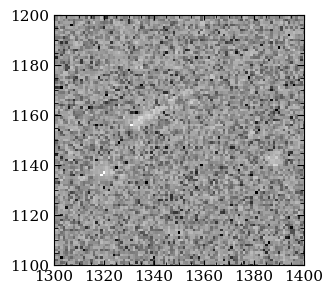

In [29]:
if example:
    
    # info = sample[sample['name'] == ex].iloc[0]
    file = fits.open(f'data/hst/raw/drc_new/{info.filename}_drc.fits')
    ccd = make_cutout(f'data/hst/raw/drc_new/{info.filename}_drc.fits', info.ra, info.dec, align_north=False, crreject=True)
    plt.imshow(-2.5*np.log10(np.abs(ccd.data/ccd.header['pxscale']**2))+ccd.header['zp'], cmap='gray_r', vmin=20, vmax=30)
    plt.xlim(1300,1400)
    plt.ylim(1100,1200)

In [30]:
for idx, row in tqdm(sample.iterrows(), total=len(sample)):
    
    # print(row['name'])
    ccd = make_cutout(f'data/hst/raw/drc_new/{row.filename}_drc.fits', row.ra, row.dec, align_north=False, crreject=True)
    hdu = ccd.to_hdu()
    hdu.writeto(f"data/hst/F814W/{row['name']}.fits", overwrite=True)
    
    
    # try:
    #     fig = plt.figure(figsize=(10,10))
    #     plt.imshow(stretch(norm(ccd)))
    #     plt.savefig(f"data/hst/png/{row['name']}.png", bbox_inches="tight")
    #     plt.close(fig)
    # except:
    #     print(f"======================== \n ERROR IN {row['name']}")

  0%|          | 0/26 [00:00<?, ?it/s]

## PSF

For each image, get the corresponding PSF centered on the object

In [31]:
psf_file = fits.open('data/hst/raw/psf/PSFSTD_WFC3UV_F814W.fits', ignore_missing_end=True)
psf_arr_flat = psf_file[0].data
psf_file.close()

???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]


Convert the PSF from 101x101x56 to a 101x101x4x7 array.

In [32]:
psf_arr = np.zeros((8,7,101,101))

for nrow in range(8):
    for ncol in range(7):
        psf_arr[nrow, ncol, :, :] = psf_arr_flat[nrow*7 + ncol, :, :]
psf_arr[psf_arr < 0] = 0

# x, y values at the center of each PSF cell
xmax = 4125
ymax = 4385
xs = np.linspace(0, xmax, 8)
ys = np.linspace(0, ymax, 9)
xs = xs[:-1] + np.diff(xs)[0]/2
ys = ys[:-1] + np.diff(ys)[0]/2

psfx = np.arange(101)
psfy = np.arange(101)
psfx = psfx + np.diff(psfx)[0]/2
psfy = psfy + np.diff(psfy)[0]/2

PSFX, PSFY = np.meshgrid(psfx, psfy)

For each galaxy, convert the ra and dec into the pixel value... ignore the rotation for this approximate test, will lead to a slight offset in the PSF.

Given an (x,y) coordinate, for each point in the 101x101 PSF array, interpolate the 7x4 PSF grid to find the PSF at that particular point.

In [33]:
def interpolate_psf(x, y): 
    
    interp = RegularGridInterpolator((ys, xs, psfy, psfx), psf_arr)
    
    pts_psfx = PSFX.flatten()
    pts_psfy = PSFY.flatten()
    
    try:
        pts_x = x*np.ones_like(pts_psfx)
        pts_y = y*np.ones_like(pts_psfy)
        pts = np.stack((pts_y, pts_x, pts_psfy, pts_psfx)).T
        val = interp(pts)
    except:
        pts_x = 2000*np.ones_like(pts_psfx)
        pts_y = 2000*np.ones_like(pts_psfy)
        pts = np.stack((pts_y, pts_x, pts_psfy, pts_psfx)).T
        val = interp(pts)

    val = val.reshape((101,101))
    return val

Now get the PSF for each galaxy

In [34]:
def get_psf(row):
    
    # Get the center of the galaxy's XY position on the original image
    galaxy_f = fits.open(f'data/hst/F814W/{row["name"]}.fits')
    header = galaxy_f[0].header
    x, y = header['X_OG'], header['Y_OG']
    
    # PSF oversampled by a factor of 4
    psf = interpolate_psf(x, y)
    
    # Reshape back to the original pixel scale
    psf_small = resize(psf, (25,25), order=3)
    
    # Write both as an HDU
    header = fits.Header()
    header['EXTNAME'] = 'PSF'
    psf_hdu = fits.ImageHDU(data=psf_small, header=header)
    header['EXTNAME'] = 'PSF_X4'
    psf_large_hdu = fits.ImageHDU(data=psf, header=header)
    
    # Write to file
    galaxy_f.append(psf_hdu)
    galaxy_f.append(psf_large_hdu)
    galaxy_f.writeto(f'data/hst/F814W/{row["name"]}.fits', overwrite=True)
    

In [35]:
for idx, row in data.iterrows():
    get_psf(row)

## Control galaxies

Control galaxies are mostly ACS, some are WFPC3, so we use TinyTim PSFs instead. Some are still WFC3 so in the WFC3 case we do as for the spogs. All three WFPC3 galaxies are taken with planetary camera (chip 1).

* Make a default parameter file with ACS/WFPC3 settings (`acs1.param`, `acs2.param`, `wfpc.param`)
* Change object-specific parameters
    * Line 2: output file name should be galaxy name
    * Line 14: should be `X Y` for the galaxy position

In [28]:
sample = data#[data.name.isin(names)]

In [18]:
! TINYTIM=/Users/liza/software/tinytim-7.5
! export TINYTIM

for idx, row in tqdm(sample.iterrows(), total=len(sample)):
    
    if 'wfc3' in row.filename:
        get_psf(row)
    # Use TinyTim to generate the PSF
    else:
        file = fits.open(f'data/hst/F814W/{row["name"]}.fits')
        header = file[0].header
        x, y = header['X_OG'], header['Y_OG']
        
        # Decide which default parameters file to use
        if 'acs' in row.filename:
            param_file = 'acs1' if 'WFC1' in header["PHOTMODE"] else 'acs2'
        else:
            param_file = 'wfpc'
        
        # Crete a new parameter file with the current x, y and filename
        with open(f'data/hst/raw/psf/{param_file}.par') as f:
            lines       = f.readlines()
        lines[1]    = f'data/hst/raw/psf/{row["name"]}\n'
        lines[13]   = f'{x} {y}\n'
        with open(f'data/hst/raw/psf/{row["name"]}.par', "w+") as f:
            f.writelines(lines)
        
        # Run TinyTim
        command1 = f"/Users/liza/software/tinytim-7.5/tiny2 data/hst/raw/psf/{row['name']}.par" 
        ! {command1}
        command2 = f"/Users/liza/software/tinytim-7.5/tiny3 data/hst/raw/psf/{row['name']}.par" 
        ! {command2}
        
        # Write the PSF to the fits file
        psf_file = fits.open(f"data/hst/raw/psf/{row['name']}00.fits")
        psf_file[0].header['EXTNAME'] = 'PSF'
        file.append(psf_file[0])
        file.writeto(f'data/hst/F814W/{row["name"]}.fits', overwrite=True)

        

  0%|          | 0/52 [00:00<?, ?it/s]

## Fix the file

We want all data to have a 4-extension FITS file, each HDU containing image -> err -> mask -> psf respectively. We also want each HDU to have an `EXTNAME` equal to `IMAGE`, `ERR`, `MASK`, or `PSF`.

In [36]:
for idx, row in tqdm(data.iterrows()):
    
    galaxy_f = fits.open(f'data/hst/F814W/{row["name"]}.fits')
        
    # Fix order and add extanmes
    try:
        hdus = [galaxy_f['SCI'], galaxy_f['UNCERT'], galaxy_f['MASK'], galaxy_f['PSF']]
        names = ['IMAGE', 'ERR', 'MASK', 'PSF']
        for hdu, name in zip(hdus, names):
            hdu.header['EXTNAME'] = name

    #     # Save file
        hdul = fits.HDUList(hdus)
        hdul.writeto(f'data/hst/F814W/{row["name"]}.fits', overwrite=True)
        print(row['name'])
    except:
        continue
        
    
    galaxy_f.close()    

0it [00:00, ?it/s]

J000318+004844
J001145-005431
J011957+133431
J080400+253051
J080724+200608
J081603+193643
J084545+200610
J085357+031034
J085943+100644
J091407+375310
J091850+420044
J092518+062334
J092820+074159
J093820+181953
J095750-001239
J100829+191620
J100848+512353
J102653+434008
J102826+573609
J103135+054057
J105751+055447
J112619+191329
J124822+551452
J133953+442237
J150619+080642
J164504+304802


In [37]:
data

,name,ra,dec,filt,filename,exptime,unit,pxscale,gain,zp,photflam,st_zp,ab_zp
0,J000318+004844,0.8259,0.8123,F814W,idas35xjq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510350e-19,25.952306,25.119596
1,J001145-005431,2.9384,-0.9085,F814W,idas09ukq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510408e-19,25.952265,25.119554
2,J011957+133431,19.9865,13.5754,F814W,idas45qyq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510273e-19,25.952361,25.119651
3,J080400+253051,120.9984,25.5143,F814W,idas34pkq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510428e-19,25.952250,25.119539
4,J080724+200608,121.8519,20.1023,F814W,idas14i7q,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510229e-19,25.952393,25.119683
5,J081603+193643,124.0131,19.6120,F814W,idas29swq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510406e-19,25.952266,25.119556
6,J084545+200610,131.4391,20.1029,F814W,idas30kiq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.511011e-19,25.951831,25.119121
7,J085357+031034,133.4867,3.1760,F814W,idas32psq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510429e-19,25.952249,25.119539
8,J085943+100644,134.9276,10.1121,F814W,idas11dnq,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510973e-19,25.951858,25.119148
9,J091407+375310,138.5301,37.8861,F814W,idas16j0q,300.0,ELECTRONS/S,0.03962,1.5,-21.1,1.510664e-19,25.952080,25.119370
